In [1]:
import matplotlib.pyplot as plt

from acquire import acquire_zillow
from prepare import prepare_zillow
from explore import explore_bivariate_categorical, explore_bivariate_continuous, test_hypothesis_correlation, test_hypothesis_ttest, explore_multivariate
from utilities import nan_null_empty_check, explore_univariate

# Attention Grabbing Title!

## Executive Summary

## Planning
Initially, I wanted to test the following possibilities:
1. Does the tax value increase as the number of bathrooms increase?
2. Does the tax value increase as the number of bedrooms increase?
3. Does the tax value increase as the total square feet incrases?
4. Does the tax value decrease with as age increases?
5. Is there a difference between tax values based on the FIPS county?

#### Data Dictionary

## Acquisition

Data was obtained from the *zillow* database using this query:
> `SELECT bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, taxamount, fips
	FROM properties_2017
		JOIN predictions_2017 USING(parcelid)
	WHERE (transactiondate BETWEEN '2017-05-01' AND '2017-08-31')
		AND (unitcnt = 1 OR propertylandusetypeid IN (261, 279, 262, 263, 264, 266, 275))
		AND calculatedfinishedsquarefeet IS NOT NULL
		AND bathroomcnt IS NOT NULL
		AND bedroomcnt IS NOT NULL
		AND fips IS NOT NULL
		AND taxvaluedollarcnt IS NOT NULL
		AND taxamount IS NOT NULL;`

Initially, using only `unitcnt = 1` did not provide adequate distribution of data points across the different FIPS county codes, so additional `propertylandusetypeid` values were used to bring in more data. Single unit properties were defined as "a property that can be purchased or rented as a single entity." These `propertylandusetypeid` values met that definition:
* 261 - single family residential 
* 262 - rural residence
* 263 - mobile home
* 264 - townhouse
* 266 - condominium
* 275 - manufactured, modular, prefabricated homes
* 279 - inferred single family residential

The acquisition was scripted with the `acquire_zillow` function.

In [2]:
zillow_df = acquire_zillow()

## Preparation

The resulting data frame was double-checked for missing values and none were found.

In [3]:
nan_null_empty_check(zillow_df)

NaN values
Empty DataFrame
Columns: [rows, columns]
Index: []
--------------------------------
Empty values
Empty DataFrame
Columns: [rows, columns]
Index: []
--------------------------------


{'nan_positions': (array([], dtype=int64), array([], dtype=int64)),
 'empty_positions': (array([], dtype=int64), array([], dtype=int64))}

The selected features were all numerical values and the only apparent task from the information on the data frame was renaming the column names.

In [4]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39358 entries, 0 to 39357
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   39358 non-null  float64
 1   bedroomcnt                    39358 non-null  float64
 2   calculatedfinishedsquarefeet  39358 non-null  float64
 3   taxvaluedollarcnt             39358 non-null  float64
 4   taxamount                     39358 non-null  float64
 5   fips                          39358 non-null  float64
 6   yearbuilt                     39358 non-null  float64
dtypes: float64(7)
memory usage: 2.1 MB


However, univariate exploration revealed that outliers were skewing the distributions of the features to the right and they would have to be removed. 1.5 * IQR was used to determine the lower and upper bounds for outliers.

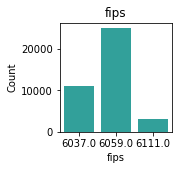

          fips  Count  Percent
6037.0  6059.0  25069    63.69
6059.0  6037.0  11080    28.15
6111.0  6111.0   3209     8.15
_________________________________________________________________


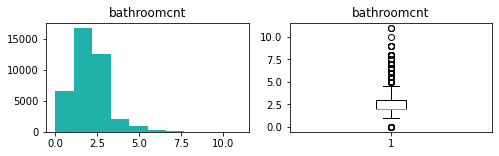

count    39358.000000
mean         2.298033
std          0.947233
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: bathroomcnt, dtype: float64


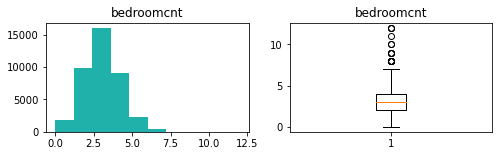

count    39358.000000
mean         3.027415
std          1.015386
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         12.000000
Name: bedroomcnt, dtype: float64


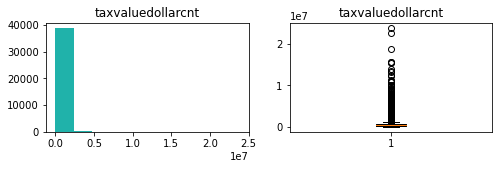

count    3.935800e+04
mean     4.969634e+05
std      6.244659e+05
min      1.000000e+03
25%      2.118865e+05
50%      3.670000e+05
75%      5.798970e+05
max      2.385837e+07
Name: taxvaluedollarcnt, dtype: float64


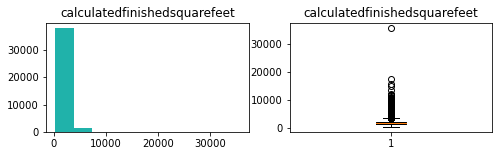

count    39358.000000
mean      1773.233523
std        945.063989
min        240.000000
25%       1180.000000
50%       1537.000000
75%       2094.000000
max      35640.000000
Name: calculatedfinishedsquarefeet, dtype: float64


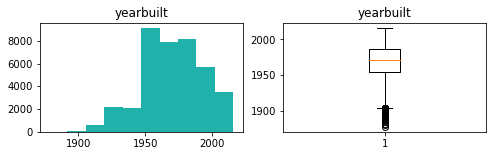

count    39358.000000
mean      1969.981046
std         23.099934
min       1878.000000
25%       1954.000000
50%       1971.000000
75%       1987.000000
max       2016.000000
Name: yearbuilt, dtype: float64


In [5]:
explore_univariate(zillow_df, ['fips'], quant_vars=['bathroomcnt', 'bedroomcnt', 'taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'yearbuilt'])

These preparation steps were scripted into the `prepare_zillow` function that returns a dictionary containing the prepared data frame of the entire population and the train, validate, test samples.  To make `yearbuilt` more continuous, it was converted to `age`, which is the difference between the current year and `yearbuilt`, and then dropped. The `tax_rate` was also calculated by dividing `tax_amount` by `tax_value` and then dropping `tax_amount` to exclude it from the model.

In [6]:
prepped_data = prepare_zillow(zillow_df)

population = prepped_data['population']
train, validate, test = prepped_data['samples']

## Exploration

#### Univariate exploration
The removal of outliers made the bathroom and bedroom distributions more normal, however, tax value and total square feet distributions remained right skewed, but to a lesser degree.

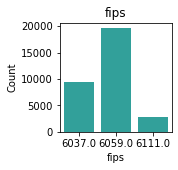

          fips  Count  Percent
6037.0  6059.0  19640    61.72
6059.0  6037.0   9386    29.50
6111.0  6111.0   2795     8.78
_________________________________________________________________


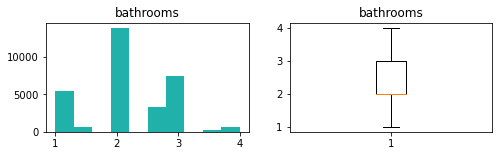

count    31821.000000
mean         2.157679
std          0.720057
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: bathrooms, dtype: float64


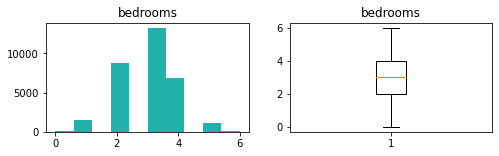

count    31821.000000
mean         2.911662
std          0.943146
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: bedrooms, dtype: float64


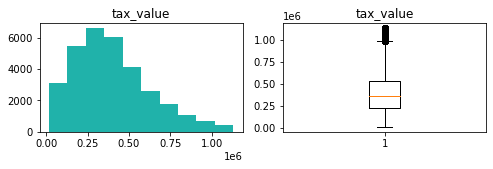

count    3.182100e+04
mean     4.003416e+05
std      2.284218e+05
min      1.543300e+04
25%      2.286530e+05
50%      3.640800e+05
75%      5.305160e+05
max      1.131770e+06
Name: tax_value, dtype: float64


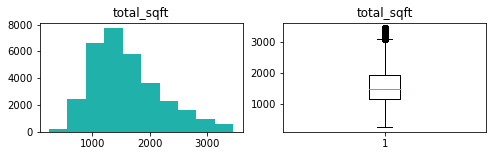

count    31821.000000
mean      1596.486220
std        601.821421
min        240.000000
25%       1154.000000
50%       1480.000000
75%       1935.000000
max       3464.000000
Name: total_sqft, dtype: float64


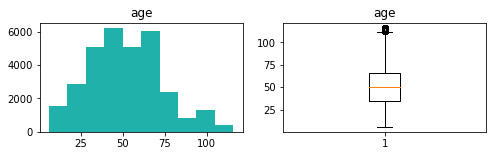

count    31821.000000
mean        51.610320
std         21.866932
min          6.000000
25%         35.000000
50%         50.000000
75%         66.000000
max        116.000000
Name: age, dtype: float64


In [7]:
explore_univariate(population, ['fips'], ['bathrooms', 'bedrooms', 'tax_value', 'total_sqft', 'age'])

When performing bivariate exploration, I found it easier to treat `fips`, `bathrooms`, and `bedrooms` as categorical values since the number of unique values were low and existed either whole or half number increments.

In [8]:
print(f"bathrooms:  {train.bathrooms.unique()}")
print(f"bedrooms:  {train.bedrooms.unique()}")
print(f"fips:  {train.fips.unique()}")

bathrooms:  [2.5 2.  1.  3.  4.  1.5 3.5]
bedrooms:  [2. 3. 4. 1. 5. 6. 0.]
fips:  [6059. 6037. 6111.]


The results led to new hypotheses to verify.

#### Bivariate Exploration

fips vs tax_value
-------------------------------


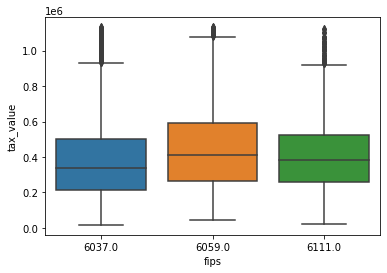

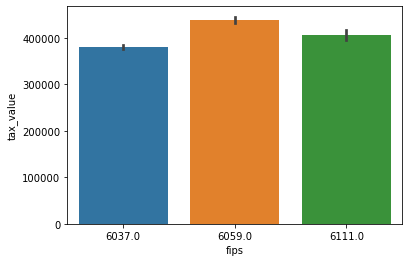

-------------------------------
Mean tax_value by fips:  
fips
6037.0    381151.942893
6059.0    438948.900612
6111.0    407447.896463
Name: tax_value, dtype: float64

bathrooms vs tax_value
-------------------------------


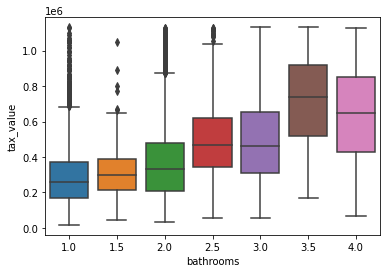

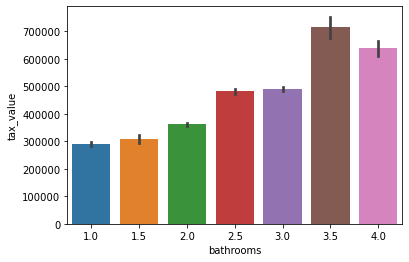

-------------------------------
Mean tax_value by bathrooms:  
bathrooms
1.0    289657.251033
1.5    307580.249357
2.0    362126.140255
2.5    482353.011860
3.0    491695.722912
3.5    715454.095808
4.0    639163.664935
Name: tax_value, dtype: float64

bedrooms vs tax_value
-------------------------------


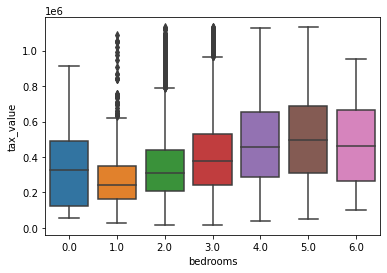

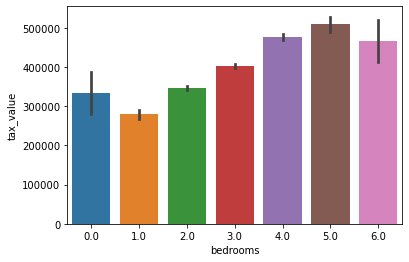

-------------------------------
Mean tax_value by bedrooms:  
bedrooms
0.0    334232.377049
1.0    279523.075775
2.0    346192.595966
3.0    403021.167998
4.0    476237.107973
5.0    509876.355140
6.0    465827.079365
Name: tax_value, dtype: float64



In [9]:
explore_bivariate_categorical('tax_value', ['fips', 'bathrooms', 'bedrooms'], train)

fips vs tax_rate
-------------------------------


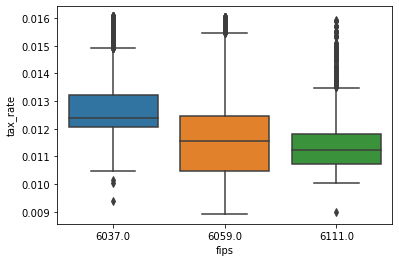

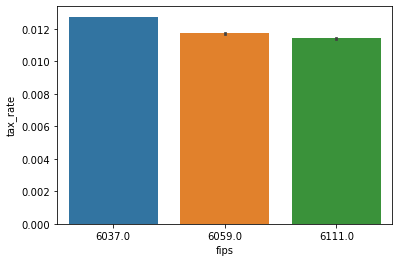

-------------------------------
Mean tax_rate by fips:  
fips
6037.0    0.012740
6059.0    0.011744
6111.0    0.011426
Name: tax_rate, dtype: float64



In [10]:
explore_bivariate_categorical('tax_rate', ['fips'], population)

age vs tax_value
-------------------------------


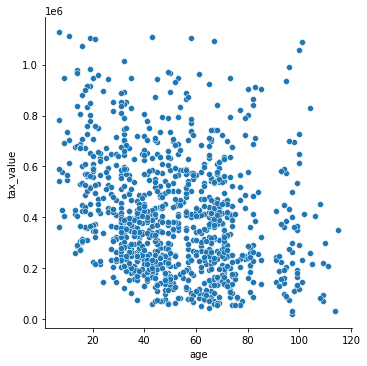

-------------------------------
Correlation between age and tax_value:  -0.24826004653680325
P value:  1.6404380154283559e-15

total_sqft vs tax_value
-------------------------------


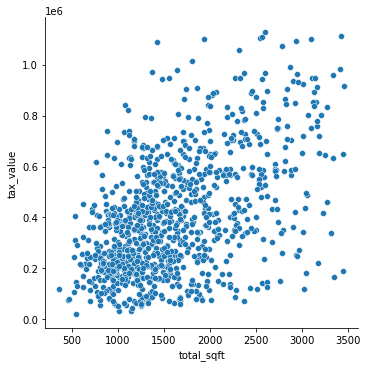

-------------------------------
Correlation between total_sqft and tax_value:  0.506061860235887
P value:  3.828077055101132e-66



In [11]:
explore_bivariate_continuous('tax_value', ['age', 'total_sqft'], train.sample(1000))

#### Hypothesis testing

I used an alpha of .05 to test my hypotheses:

In [12]:
alpha = .05

1. Is there a positive correlation between number of bathrooms and tax value?

In [13]:
null_hyp = "There is no correlation between bathrooms and tax value"
alt_hyp = "There is a correlation between bathrooms and tax value"

test_hypothesis_correlation('bathrooms', 'tax_value', train, null_hyp, alt_hyp)

------------------------------------------
corr:  0.3686470641378871, p:  0.0, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  There is a correlation between bathrooms and tax value
Correlation direction:  positive
------------------------------------------


2. Is there a positive correlation between number of bedrooms and tax value?

In [14]:
null_hyp = "There is no correlation between bedrooms and tax value"
alt_hyp = "There is a correlation between bedrooms and tax value"

test_hypothesis_correlation('bedrooms', 'tax_value', train, null_hyp, alt_hyp)

------------------------------------------
corr:  0.24384747553186353, p:  1.6363649512191054e-239, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  There is a correlation between bedrooms and tax value
Correlation direction:  positive
------------------------------------------


3. Is there a positive correlation between total square feet and tax value?

In [15]:
null_hyp = "There is no correlation between total square feet and tax value"
alt_hyp = "There is a correlation between total square feet and tax value"

test_hypothesis_correlation('total_sqft', 'tax_value', train, null_hyp, alt_hyp)

------------------------------------------
corr:  0.46934291789995974, p:  0.0, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  There is a correlation between total square feet and tax value
Correlation direction:  positive
------------------------------------------


4. Is there a negative correlation between age and tax value?

In [16]:
null_hyp = "There is no correlation between age and tax value"
alt_hyp = "There is a correlation between age and tax value"

test_hypothesis_correlation('age', 'tax_value', train, null_hyp, alt_hyp)

------------------------------------------
corr:  -0.19584372329114047, p:  1.4862653452984842e-153, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  There is a correlation between age and tax value
Correlation direction:  negative
------------------------------------------


5. Do FIPS 6059 properties have a higher tax value than the population?

In [17]:
null_hyp = "The tax value for FIPS 6059 properties is not higher than the mean tax value"
alt_hyp = "The tax value for FIPS 6059 properties is higher than the mean tax value"
fips_6059 = train[train.fips_6059 == 1]

test_hypothesis_ttest('tax_value', fips_6059, train, null_hyp, alt_hyp)

------------------------------------------
t:  11.922496186588239, p:  2.3643582662014837e-32, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  The tax value for FIPS 6059 properties is higher than the mean tax value
------------------------------------------


6. Do properties with 3.5 bathrooms have a higher tax value than the population?

In [18]:
null_hyp = "The tax value for 3.5 bathrooms is not higher than the mean tax value"
alt_hyp = "The tax value for 3.5 bathrooms is higher than the mean tax value"
bath_35 = train[train.bathrooms == 3.5] 

test_hypothesis_ttest('tax_value', bath_35, train, null_hyp, alt_hyp)

------------------------------------------
t:  16.23715782652534, p:  4.135237540554219e-36, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  The tax value for 3.5 bathrooms is higher than the mean tax value
------------------------------------------


7. Do properties with 5 bedrooms have a higher tax value than the population?

In [19]:
null_hyp = "The tax value for 5 bedrooms is not higher than the mean tax value"
alt_hyp = "The tax value for 5 bedrooms is higher than the mean tax value"
bedrooms_5 = train[train.bedrooms == 5] 

test_hypothesis_ttest('tax_value', bedrooms_5, train, null_hyp, alt_hyp)

------------------------------------------
t:  10.551947153524317, p:  4.130574771479273e-24, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  The tax value for 5 bedrooms is higher than the mean tax value
------------------------------------------


#### Multivariate exploration

total_sqft vs tax_value
-------------------------------


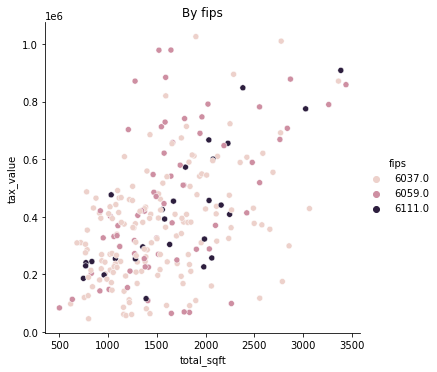

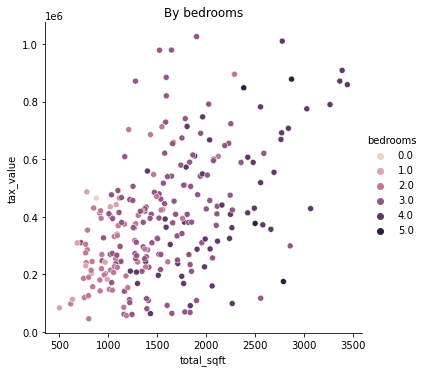

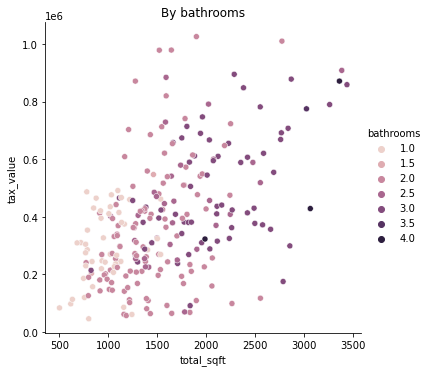


age vs tax_value
-------------------------------


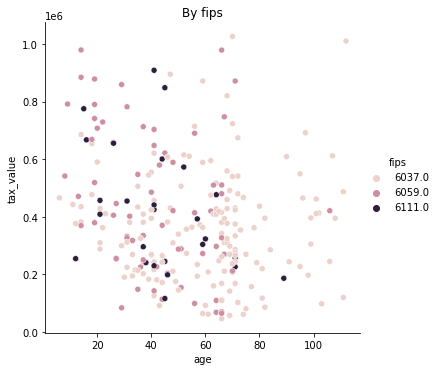

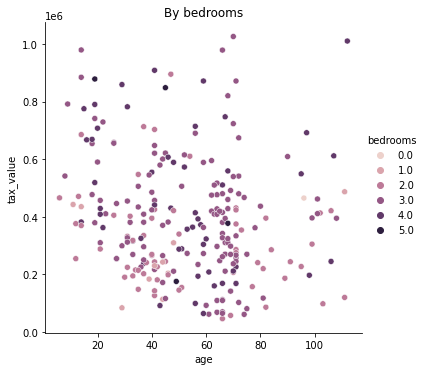

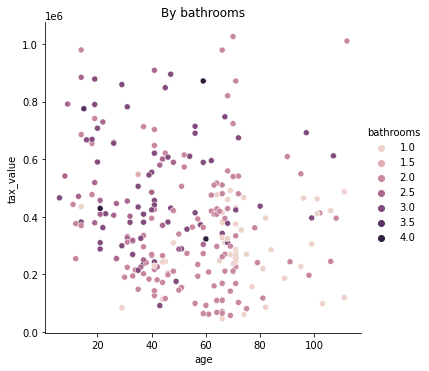

In [20]:
explore_multivariate(['total_sqft', 'age'], ['fips', 'bedrooms', 'bathrooms'], 'tax_value', train.sample(250))

## Modeling